# CLAS12 Affinity Calculations
### Rowan Kelleher

#### This Notebook was created for calculating affinity values from CLAS12 MC data, and then analyzing the results

To use the notebook, first import all necessary imports below:

In [29]:
from ROOT import TFile,TTree,TCanvas,TH1F,gStyle,TLatex,gPad,TLegend,TLorentzVector,TH2F,TLine,TF1,TBox,RDataFrame,TPad,TF2
import ROOT
import numpy as np
import awkward as awk
import uproot
import pandas as pd
import matplotlib.pyplot as plot
from pandas import read_excel 
from copy import deepcopy
from ipywidgets import *
import logging, os 
logging.disable(logging.WARNING) 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
print("tf.__version__", tf.__version__)


tf.__version__ 2.7.0


This notebook takes in root files and converts them to numpy arrays using uproot.
On the next line, we pull each tree from the root file (one tree per kinematic variable we binned)

Here we open the file in uproot and sort the trees into their respective objects

In [30]:
#up4_file = uproot.open("../OutputFiles/AffinityFiles/Files_9_5/Exactfile4.root")
up4_file = uproot.open("../OutputFiles/Slurm/Sept_5/Sept5_run2_0.root")
up4_z = up4_file["tree_z_h_bins"]
up4_x = up4_file["tree_x_bins"]
up4_Mh = up4_file["tree_Mh_bins"]

Now we must fill the arrays. We need to create two that have 6 arrays of length 7 inside them, as these are the arrays for the x and z binnings. This data doesn't include x or z as the center of the bin will be used as the x and z value. For the Mh binning, Mh isn't necessary for calculating Affinity so all the data is already in the array

In [31]:
#0 is z, 1 is x, 2 is mh
zarray = np.array([np.zeros(7)] * 6)
xarray = np.array([np.zeros(7)] * 6)
Mharray = np.array([np.zeros(7)] * 7)
xkinematics = np.array(["z_h", "Q2", "pT", "R0", "R1", "R2"])
zkinematics = np.array(["x", "Q2", "pT", "R0", "R1", "R2"])
Mhkinematics = np.array(["x", "z_h", "Q2", "pT", "R0", "R1", "R2"])

#These arrays each hold an array for each variable, meaning that the first bin of variables is in the first index of every kinematics array

#z
for i in range(zkinematics.size):
    zarray[i] = up4_z[zkinematics[i]].array(library = "np")
#x
for i in range(xkinematics.size):
    xarray[i] = up4_x[xkinematics[i]].array(library = "np")
#Mh
for i in range(Mhkinematics.size):
    Mharray[i] = up4_Mh[Mhkinematics[i]].array(library = "np")

Now we need to transpose the array. When we filled the arrays with uproot, we put each kinematic in its own array, with those array's indices marking the bin number. Now we want each bin number to have all the kinematics for that bin in one array so we can feed that array to the calculator:

In [32]:
xarray = np.transpose(xarray)
zarray = np.transpose(zarray)
Mharray = np.transpose(Mharray)

This code block uses tensor flow to set up models and predictions based on those models. The user does not need to edit this.

In [33]:
collinear_region_name = 'collinear'
current_region_name = 'current'
target_region_name = 'target'
TMD_region_name = 'TMD'
soft_region_name = 'soft'
collinear_lable_name = 'collinearaff'
target_lable_name = 'targetaff'
current_lable_name = 'currentaff'
TMD_lable_name = 'tmdaff'
soft_lable_name = 'softaff'

tmd_model_name = '../../SIDIS-Affinity/models/final_%s' % TMD_region_name
tmd_model = tf.keras.models.load_model(tmd_model_name)
target_model_name = '../../SIDIS-Affinity/models/final_%s' % target_region_name
target_model = tf.keras.models.load_model(target_model_name)
collinear_model_name = '../../SIDIS-Affinity/models/final_%s' % collinear_region_name
collinear_model = tf.keras.models.load_model(collinear_model_name)
current_model_name = '../../SIDIS-Affinity/models/final_%s' % current_region_name
current_model = tf.keras.models.load_model(current_model_name)
soft_model_name = '../../SIDIS-Affinity/models/final_%s' % soft_region_name
soft_model = tf.keras.models.load_model(soft_model_name)

Here we add our binning so that we can use these values in the affinity calculations

In [34]:
Mhbins = np.linspace(0.3,1.3,7)
xbins = np.array([0.1,0.13,0.16,0.19,0.235,0.3,0.5])
zbins = np.array([0.35,0.43,0.49,0.55,0.62,0.7,0.83])

Now we create the calculator. Here is how the function works:
1. calculator() takes in an array with kinematics, the region (tmd for this study), the name of the variable that we binned, and then the actual value for the center of that bin
1. Depening on the name of the binned variable, the function assigns all the necessary kinematics, and fills in the gaps (if applicable) with the center of the bin
1. After the kinematics are input, a panda dataframe is created mapping the kinematics to its respective place
1. The applicable prediction is then made based on the region (tmd, target, etc)
1. The prediction, or affinity value, is returned
Hence, to calculate affinity yourself, you just need to call the calculator with your array, region, bin name, and bin variable

In [35]:
def calculator(array, region, binType, binnedVariable = 0):
    if binType == "x":
        z = array[0]
        Q2 = array[1]
        pT = array[2]
        R0max = array[3]
        R1max = array[4]
        R2max = array[5]
        x = binnedVariable
    elif binType == "z":
        x = array[0]
        Q2 = array[1]
        pT = array[2]
        R0max = array[3]
        R1max = array[4]
        R2max = array[5]
        z = binnedVariable
    elif binType == "Mh":
        x = array[0]
        z = array[1]
        Q2 = array[2]
        pT = array[3]
        R0max = array[4]
        R1max = array[5]
        R2max = array[6]
        
    test_features = pd.DataFrame({'pT':pT,'Q2':Q2,'x':x,'z':z,'R0max':R0max,'R1max':R1max,'R2max':R2max},index=[0])

    if region == 'tmd':
        prediction = tmd_model.predict(test_features).flatten()
        
    elif region == 'target':
        prediction = target_model.predict(test_features).flatten()
        
    elif region == 'collinear':
        prediction = collinear_model.predict(test_features).flatten()

    elif region == 'soft':
        prediction = soft_model.predict(test_features).flatten()

    else:
        prediction = current_model.predict(test_features).flatten()

    return prediction[0] #returns affinity value

In [36]:
xaffinity = np.zeros(7)
zaffinity = np.zeros(7)
Mhaffinity = np.zeros(7)
for i in range(7):
    zaffinity[i] = calculator(zarray[i], "tmd", "z", zbins[i])
    xaffinity[i] = calculator(xarray[i], "tmd", "x", xbins[i])
    Mhaffinity[i] = calculator(Mharray[i], "tmd", "Mh")

In [37]:
print(zaffinity)
print(Mhaffinity)
print(xaffinity)

[0.00717792 0.01711097 0.04022014 0.04332352 0.05090615 0.06545794
 0.07930681]
[0.01737005 0.0289371  0.03866744 0.03552398 0.0384734  0.06135333
 0.06616631]
[0.05109102 0.04519099 0.03265235 0.02296692 0.02657241 0.01598009
 0.00421783]


[Text(0.5, 0, 'z_h')]

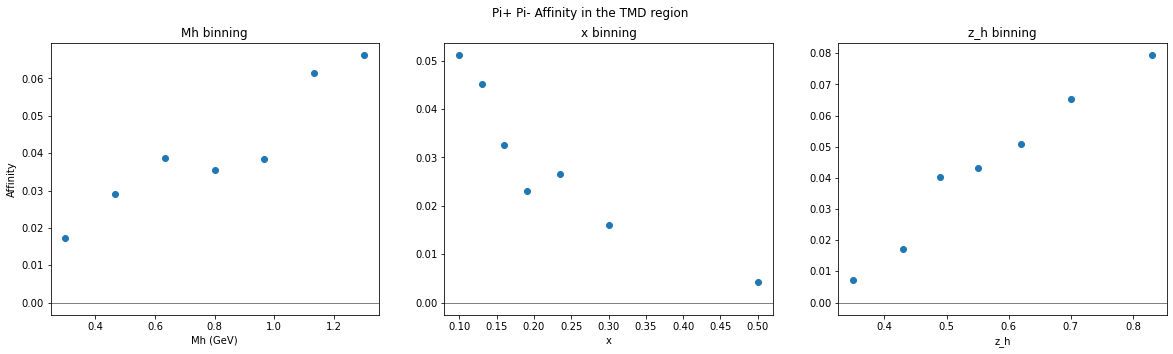

In [38]:
fig, (ax1, ax2, ax3) = plot.subplots(1, 3, figsize = (20, 5))
fig.suptitle("Pi+ Pi- Affinity in the TMD region")
ax1.set(ylabel = "Affinity")
ax1.scatter(Mhbins, Mhaffinity)
ax1.axhline(y=0, color="gray", lw = 1)
ax1.set_title("Mh binning")
ax1.set(xlabel = "Mh (GeV)")
ax2.scatter(xbins, xaffinity)
ax2.axhline(y=0, color="gray", lw = 1)
ax2.set_title("x binning")
ax2.set(xlabel = "x")
ax3.scatter(zbins, zaffinity)
ax3.axhline(y=0, color="gray", lw = 1)
ax3.set_title("z_h binning")
ax3.set(xlabel = "z_h")
